# Big Blue Bus speeds using `vp_usable_with_dwell`, comparison w/ legacy speedmaps

## (based on 37)

> ## Alignments
> * Align nearest neighbor and interpolation steps
> * Dwell times are factored in
> * Interpolation of stop arrival looks at the previous `moving_timestamp_local` which is after the bus gets moving again, and this stop's `location_timestamp_local`, which is the beginning of the bus's dwelling at a stop.

> ## Speed
> * Retain how speed is calculated - even remove filters (in averaging, speeds over 80 mph are filtered out) to show full distribution
> * In the full distribution, we'll keep extra high speeds in, and decide on where are high/low filters should be

In [1]:
import folium
import geopandas as gpd
import pandas as pd

from segment_speed_utils.project_vars import SEGMENT_GCS
from shared_utils import rt_dates, rt_utils

analysis_date = rt_dates.DATES["apr2024"]

In [2]:
from rt_analysis import rt_filter_map_plot
import datetime as dt
from siuba import *
from tqdm.notebook import tqdm

In [3]:
speeds = pd.read_parquet(
    f"{SEGMENT_GCS}bbb_speeds_by_trip_{analysis_date}.parquet"
)
   
segment_speeds = gpd.read_parquet(
    f"{SEGMENT_GCS}bbb_segment_speeds_gdf_{analysis_date}.parquet"
)

In [4]:
speeds[speeds.speed_mph <= 80].speed_mph.describe()

count    32161.000000
mean        14.200993
std          8.277521
min          0.033953
25%          8.890265
50%         12.699928
75%         17.480291
max         79.641062
Name: speed_mph, dtype: float64

<AxesSubplot:>

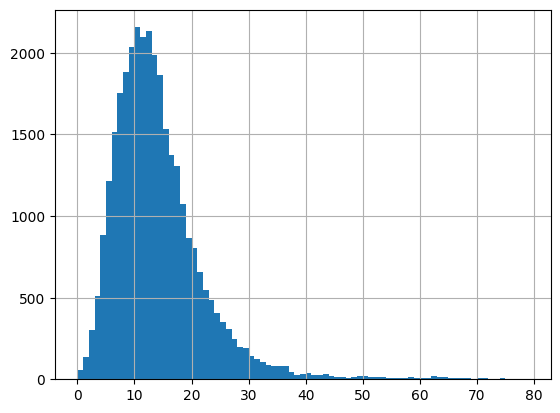

In [5]:
speeds.speed_mph.hist(bins=range(0, 80, 1))

## comparison -- all trip speeds 

*  substantially equivalent!

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
rt_day = rt_filter_map_plot.from_gcs(300, analysis_date, pbar)

found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_300_2024-04-17.parquet


In [9]:
rt_day.segment_speed_map(no_render=True) # calculate all speeds

stop_speeds shape: (0, 17), shape_id: 26773
stop speeds gdf is empty!


In [25]:
legacy_all_day = rt_day.stop_segment_speed_view.copy()

In [26]:
legacy_all_day >> arrange(-_.n_trips_shp) >> head(3)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_id,stop_sequence,route_id,route_short_name,direction_id,...,meters_from_last,speed_from_last,delay_chg_sec,speed_mph,n_trips_shp,p50_mph,p20_mph,p80_mph,fast_slow_ratio,trips_per_hour
29252,616,CENTURY EB & AVIATION NS,"LINESTRING (149725.104 -450726.953, 149755.002...",26730,16670.916411,918827,37.0,3707,3,1.0,...,328.488683,2.507547,0.0,5.609383,114,16.469685,6.768571,24.653475,3.642346,3.268945
29253,None,None,"LINESTRING (149848.468 -450938.303, 149878.806...",26730,18000.000000,918827,37.0,3707,3,1.0,...,1329.083589,16.013055,NaN,35.821205,114,16.469685,6.768571,24.653475,3.642346,3.268945
29254,616,CENTURY EB & AVIATION NS,"LINESTRING (149725.104 -450726.953, 149755.002...",26730,16670.916411,918826,37.0,3707,3,1.0,...,328.488683,3.189211,0.0,7.134264,114,16.469685,6.768571,24.653475,3.642346,3.268945


In [28]:
legacy_all_day[legacy_all_day.speed_mph <= 80].speed_mph.describe()

count    29482.000000
mean        14.103988
std          8.354021
min          0.238520
25%          8.649934
50%         12.560240
75%         17.460138
max         79.567103
Name: speed_mph, dtype: float64

<AxesSubplot:>

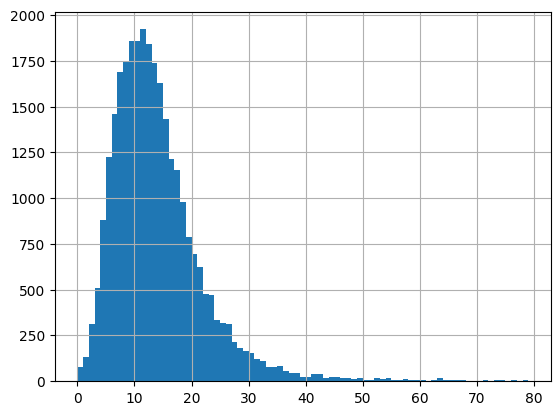

In [29]:
legacy_all_day.speed_mph.hist(bins=range(0, 80, 1))

## Aggregations diverge?

* comparison isn't 1:1, speedmaps here are a single, all-day agg while segment speeds is both peak and offpeak aggs
* just look at p20 for now, but others show same patterns

In [24]:
for i in range(25):
    print(f'{i}, {rt_utils.categorize_time_of_day(i)}') #  rt_segment_speeds peak is this AM + PM

0, Owl
1, Owl
2, Owl
3, Owl
4, Early AM
5, Early AM
6, Early AM
7, AM Peak
8, AM Peak
9, AM Peak
10, Midday
11, Midday
12, Midday
13, Midday
14, Midday
15, PM Peak
16, PM Peak
17, PM Peak
18, PM Peak
19, PM Peak
20, Evening
21, Evening
22, Evening
23, Evening
24, Evening


In [30]:
legacy_all_day.p20_mph.describe() #  ignore count, showing unaggregated...

count    29482.000000
mean         9.464578
std          3.994089
min          0.353960
25%          6.885652
50%          8.976900
75%         11.322425
max         72.619081
Name: p20_mph, dtype: float64

In [17]:
segment_speeds.p20_mph.describe()

count    67701.000000
mean         6.209578
std          3.949743
min          0.050000
25%          3.700000
50%          5.610000
75%          7.790000
max         65.790000
Name: p20_mph, dtype: float64

<AxesSubplot:>

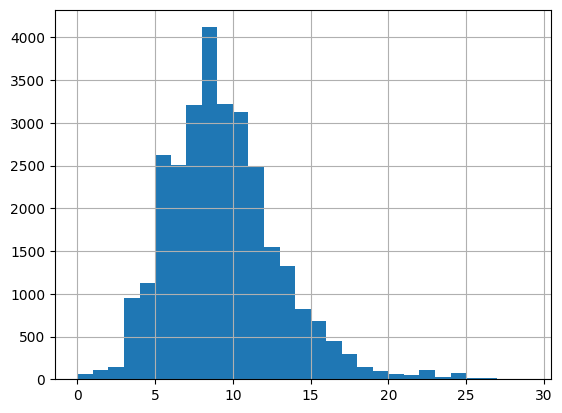

In [51]:
legacy_all_day.p20_mph.hist(bins=range(0, 30, 1))

<AxesSubplot:>

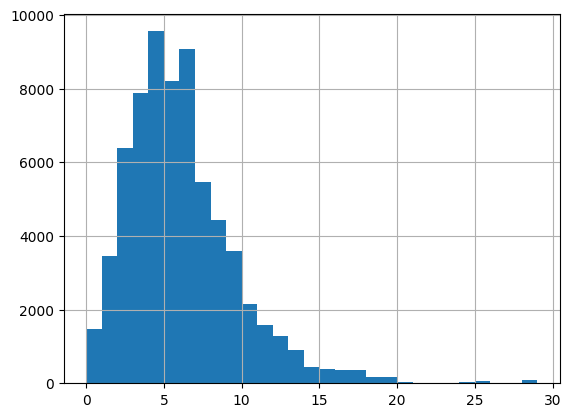

In [52]:
segment_speeds.p20_mph.hist(bins=range(0, 30, 1))

## segment Peak vs speedmaps AM

In [37]:
rt_day.set_filter(start_time='07:00', end_time='10:00')

In [38]:
rt_day.segment_speed_map(no_render=True) # calculate all speeds

stop_speeds shape: (0, 17), shape_id: 26773
stop speeds gdf is empty!


In [39]:
legacy_am = rt_day.stop_segment_speed_view.copy()

In [40]:
segment_speeds_peak = segment_speeds[segment_speeds['peak_offpeak'] == 'peak']

In [41]:
legacy_am.p20_mph.describe() #  ignore count, showing unaggregated...

count    5888.000000
mean       10.486114
std         4.847688
min         0.436987
25%         7.308957
50%        10.085025
75%        12.501387
max        63.914286
Name: p20_mph, dtype: float64

In [42]:
segment_speeds_peak.p20_mph.describe()

count    34087.000000
mean         5.984834
std          3.731273
min          0.260000
25%          3.730000
50%          5.360000
75%          7.420000
max         63.910000
Name: p20_mph, dtype: float64

<AxesSubplot:>

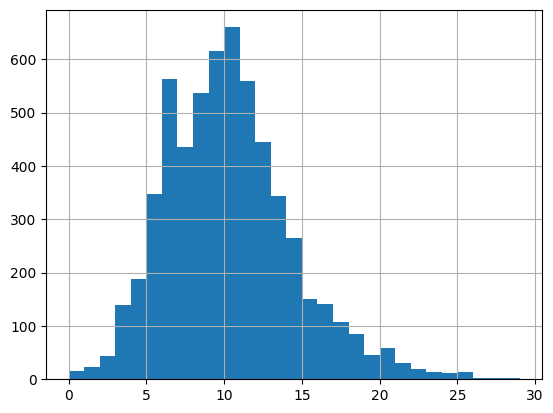

In [53]:
legacy_am.p20_mph.hist(bins=range(0, 30, 1))

<AxesSubplot:>

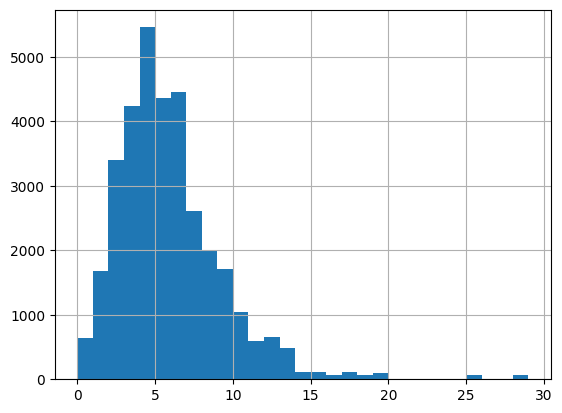

In [54]:
segment_speeds_peak.p20_mph.hist(bins=range(0, 30, 1))

In [47]:
# rt_day.stop_segment_speed_view.p50_mph.describe()

In [48]:
# segment_speeds.p50_mph.describe()

In [49]:
# rt_day.stop_segment_speed_view.p80_mph.describe()

In [50]:
# segment_speeds.p80_mph.describe()

## segment Peak vs speedmaps PM

In [55]:
rt_day.set_filter(start_time='15:00', end_time='20:00')

In [56]:
rt_day.segment_speed_map(no_render=True) # calculate all speeds

In [58]:
legacy_pm = rt_day.stop_segment_speed_view.copy()

In [59]:
legacy_pm.p20_mph.describe() #  ignore count, showing unaggregated...

count    9254.000000
mean        9.086085
std         4.418013
min         0.734085
25%         6.213072
50%         8.455280
75%        11.271350
max        72.619081
Name: p20_mph, dtype: float64

In [60]:
segment_speeds_peak.p20_mph.describe()

count    34087.000000
mean         5.984834
std          3.731273
min          0.260000
25%          3.730000
50%          5.360000
75%          7.420000
max         63.910000
Name: p20_mph, dtype: float64

<AxesSubplot:>

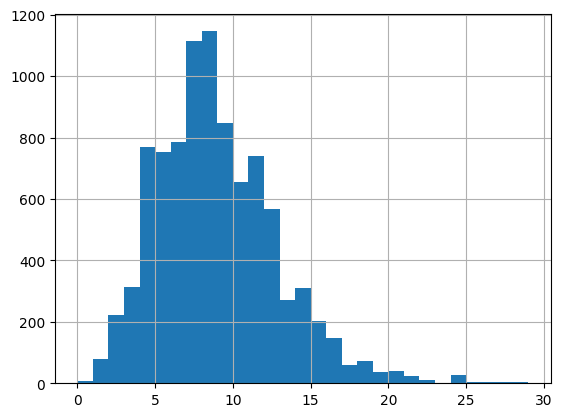

In [61]:
legacy_pm.p20_mph.hist(bins=range(0, 30, 1))

<AxesSubplot:>

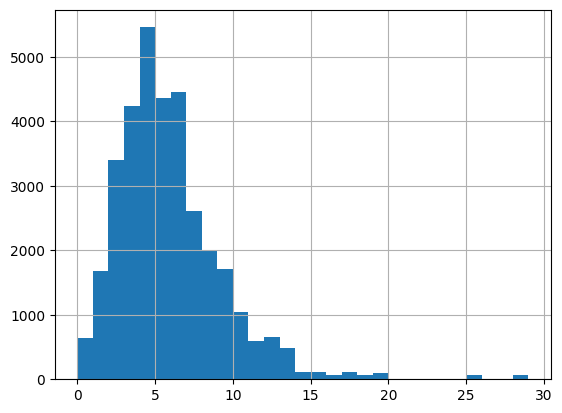

In [62]:
segment_speeds_peak.p20_mph.hist(bins=range(0, 30, 1))